In [1]:
import torch
import torchvision
import glob
import cv2
import PIL
import time
import matplotlib.pyplot as plt
from unet import UNet
import numpy as np
import random
import tqdm
from IPython.display import HTML, display, clear_output
from torch.utils.tensorboard import SummaryWriter
import albumentations as A
from timm.scheduler import CosineLRScheduler
import MyUtil
import imgsim
import skimage.metrics


In [2]:
# データセット設定
class dataset_faces(torch.utils.data.Dataset):
    def __init__(self, fileName, transform_main=None):
        self.transform_main = transform_main

        self.fileName = fileName
        self.fileList = glob.glob(fileName + "/*")

    def __len__(self):
        output = len(self.fileList)
        return output

    def __getitem__(self, idx):
        img = self.my_imread(self.fileList[idx])
        img = self.transform_main(img)
        return self.linedraw(img),img

    def my_imread(self, filename):
        try:
            img = cv2.imdecode(np.fromfile(filename, np.uint8), cv2.IMREAD_COLOR)
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            return img
        except Exception as e:
            print(e)
            return None

    def linedraw(self, x):
        transform = torchvision.transforms.Grayscale(3)
        x = transform(x)
        
        # 3x3カーネルで膨張1回（膨張はMaxPoolと同じ）
        dilated = torch.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        # 膨張の前後でL1の差分を取る
        diff = torch.abs(x - dilated)
        # ネガポジ反転
        x = 1.0 - diff
        return x


# データセット設定
class dataset_faces_test(torch.utils.data.Dataset):
    def __init__(self, fileName, transform_main=None):
        # self.transform_main =  torchvision.transforms.ToTensor()
        self.transform_main = transform_main

        self.fileName = fileName
        self.fileList = glob.glob(fileName + "/*")

    def __len__(self):
        output = len(self.fileList)
        return output

    def __getitem__(self, idx):
        # img = PIL.Image.fromarray(self.my_imread(self.fileList[idx]))
        img = self.my_imread(self.fileList[idx])
        

        img = self.transform_main(img)
        return self.linedraw(img), img

    def my_imread(self, filename):
        try:
            img = cv2.imdecode(np.fromfile(filename, np.uint8), cv2.IMREAD_COLOR)
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            return img
        except Exception as e:
            print(e)
            return None

    def linedraw(self, x):
        transform = torchvision.transforms.Grayscale(3)
        x = transform(x)
        # 3x3カーネルで膨張1回（膨張はMaxPoolと同じ）
        dilated = torch.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        # 膨張の前後でL1の差分を取る
        diff = torch.abs(x - dilated)
        # ネガポジ反転
        x = 1.0 - diff
        return x


In [3]:
# 割り込み停止検知（KeyboardInterruptで保存）
def SaveOnKI(funk):
    def _inner(*args):
        try:
            funk(*args)
        except KeyboardInterrupt:
            print("停止を検知しました")
            torch.save(args[0].params["model"].state_dict(), f"{int(time.time())}_LatestModel.pth")
            print(f"{int(time.time())}_LatestModel.pthに保存しました。")

    return _inner
class ImgsimLoss(torch.nn.Module):
    def __init__(self, devices):  # パラメータの設定など初期化処理を行う
        super(ImgsimLoss, self).__init__()
        self.vtr = imgsim.Vectorizer()
        self.devices = devices

    def forward(self, outputs, targets):  # モデルの出力と正解データ
        dist = []
        for i, j in zip(outputs, targets):

            a = ((i).to("cpu").detach().numpy().transpose(1, 2, 0)) * 255
            b = ((j).to("cpu").detach().numpy().transpose(1, 2, 0)) * 255
            a = a.astype(np.uint8)
            b = b.astype(np.uint8)
            # print(a)
            vec0 = self.vtr.vectorize(a)
            vec1 = self.vtr.vectorize(b)

            dist.append(imgsim.distance(vec1, vec0))
        return torch.mean(torch.tensor(dist, requires_grad=True)).to(self.devices)


class MyKLDivLoss(torch.nn.Module):
    def __init__(self):  # パラメータの設定など初期化処理を行う
        super(MyKLDivLoss, self).__init__()

    def forward(self, outputs, targets):  # モデルの出力と正解データ
        return (outputs * (outputs / targets).log()).sum()
        
class MultiMSELoss(torch.nn.Module):
    def __init__(self):  # パラメータの設定など初期化処理を行う
        super(MultiMSELoss, self).__init__()
        self.criterion = torch.nn.MSELoss()
        

    def forward(self, outputs, targets):  # モデルの出力と正解データ
        dist = []
        
        print(outputs.size())
        for output,target in zip(outputs,targets):
            var=[]
            for i in range(0,3):
                var.append(torch.tensor(self.criterion( output[i],target[i]), requires_grad=True))
                print(torch.stack(var))

            dist.append(torch.stack(var))
        return torch.mean(torch.cat(dist))

In [4]:
# グローバル設定
class paramsSetting:
    def __init__(self):
        # temsolboard用ファイル設定
        self.writer = SummaryWriter("runs/pico1")

        # データ拡張設定
        self.auglist = [
            A.RandomScale((-0.5, 1.5)),
            A.RandomSizedCrop((360, 360), 128, 128),
            A.Flip(p=0.5),
            
        ]
        self.albtrans = MyUtil.AlbTransToTVLambda(self.auglist)

        self.transforms = torchvision.transforms.Compose(
            [
                torchvision.transforms.Lambda(self.albtrans),
                torchvision.transforms.ToTensor(),
            ]
        )  # torchvision.transforms.AugMix(),

        # データセット定義
        self.linedataset = dataset_faces("image", self.transforms)

        # データ分割率
        self.split_rate = 0.9

        self.train_dataset, self.val_dataset = torch.utils.data.random_split(
            self.linedataset,
            [
                int(len(self.linedataset) * self.split_rate),
                len(self.linedataset) - int(len(self.linedataset) * self.split_rate),
            ],
        )

        # 学習用データローダー
        self.train_loader = torch.utils.data.DataLoader(
            self.train_dataset, batch_size=94, shuffle=True, pin_memory=True
        )
        self.val_loader = torch.utils.data.DataLoader(self.val_dataset, batch_size=94, shuffle=True, pin_memory=True)
        self.test_loader = torch.utils.data.DataLoader(
            dataset_faces_test("image", self.transforms), batch_size=1, pin_memory=True
        )

        # モデル定義
        self.model = UNet(1, 1)

        # デバイスモデル設定
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # 損失関数
        #self.criterion = torch.nn.CrossEntropyLoss()
        #self.criterion = torch.nn.BCELoss()
        self.criterion = torch.nn.L1Loss()
        # self.criterion = pytorch_ssim.SSIM(window_size=11)
        # self.criterion = torch.nn.MSELoss(reduction="sum")

        # 最適化関数
        self.optimizer = torch.optim.RAdam(self.model.parameters(), lr=1e-3)

        # スケジューラー
        self.scheduler = CosineLRScheduler(
            self.optimizer, t_initial=100, lr_min=1e-6, warmup_t=3, warmup_lr_init=1e-6, warmup_prefix=True
        )

        # 総エポック数
        self.EPOCHS = 500

        #早期打ち止めの継続回数
        self.early_stopping_count=100

    def __getitem__(self, key):
        return eval("self." + key)


In [5]:
class trainer:
    def __init__(self, params) -> None:
        self.params = params
        self.stopcount = MyUtil.early_stopping(params["early_stopping_count"])

    @SaveOnKI
    def train(self):
        """
        学習のメイン部分
        １エポックごとに学習評価を繰り返し進み具合を評価する
        """

        self.params["model"].to(self.params["device"])
        for epoch in range(self.params["EPOCHS"]):

            display(HTML(f"<h1>Now EPOCH : {epoch}/" + str(self.params["EPOCHS"]) + "</h1><br>"))
            
            #学習
            trainloss = self.__train(epoch)
            #評価
            val_loss, output = self.__eval()

            self.params["writer"].add_scalars("loss", {"val_loss": val_loss, "train_loss": trainloss}, epoch)

            self.params["writer"].add_image(
                tag="Data test", img_tensor=torchvision.utils.make_grid(torch.cat(output)), global_step=epoch
            )

            #10epochごとに保存
            if epoch % 10 == 0:
                torch.save(
                    self.params["model"].state_dict(), f"epoch{epoch}_valid_loss{round(val_loss.item(), 3)}_Model.pth"
                )

            #セルのクリア
            clear_output(wait=True)
            #early_stopping判定
            self.stopcount.check(val_loss)

    def __train(self, epoch):
        """
        トレーニング部分
        """
        self.params["model"].train()  # モデルを学習モードに重要）

        trainloss = 0
        countBatchT = 0

        for batch in tqdm.auto.tqdm(self.params["train_loader"], desc="train"):
            self.params["optimizer"].zero_grad()  # 必須

            # batch (batch_size, channel, size, size)
            # バッチアンパック
            image, label = batch

            image = image.to(self.params["device"])
            label = label.to(self.params["device"])

            preds = self.params["model"](image)  # 予測部分
            preds=preds*image
            
            # 損失を計算
            loss = self.params["criterion"](preds, label)  # 必須
            

            # 損失の伝番
            loss.backward()  # 必須

            self.params["optimizer"].step()  # 必須

            trainloss = trainloss + loss
            countBatchT = countBatchT + 1
        else:
            self.params["scheduler"].step(epoch)

        return trainloss / countBatchT

    def __eval(self):
        """
        評価部分
        """
        # 評価モードにする
        self.params["model"].eval()  

        valiloss = 0
        countBatchV = 0

        with torch.inference_mode():  # 勾配計算など学習関係のメモリを使用しない
            for batch in tqdm.auto.tqdm(self.params["val_loader"], desc="valid"):
                image, label = batch  # (batch_size, channel, size, size)

                image = image.to(self.params["device"])
                label = label.to(self.params["device"])

                #モデルに代入
                preds = self.params["model"](image)
                preds=preds*image

                #損失計算
                loss = self.params["criterion"](preds, label)  # 必須
                
                
                valiloss = valiloss + loss
                countBatchV = countBatchV + 1

        return valiloss / countBatchV, [image[0:8], label[0:8], preds[0:8]]

    def test(self, modelPath=None, gcam=True):
        """
        テスト部分
        """
        model = self.params["model"].to(self.params["device"])
        self.params["model"].eval()  # 評価モードにする
        
        if modelPath:
            #print(torch.load(modelPath))
            model.load_state_dict(torch.load(modelPath))

        with torch.inference_mode():
            for batch in self.params["test_loader"]:
                image, label = batch
                break
            image = image.to(self.params["device"])
            label = label.to(self.params["device"])

            preds = model(image)
            preds=preds*image
            loss = self.params["criterion"](preds, label)  # 必須
            print(loss.item())
        return [image, label, preds]


In [6]:
# seedを固定
MyUtil.torch_fix_seed(1582)
params = paramsSetting()


torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128])


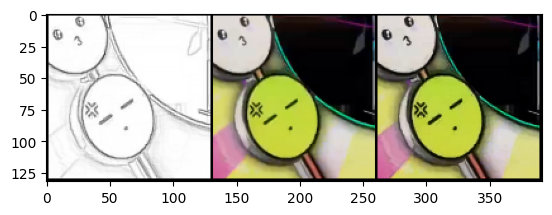

In [7]:
# データ確認ゾーン
def show_tensor(input_image_tensor):
    # writer.add_image(tag="img",img_tensor=input_image_tensor,global_step=f)
    img = input_image_tensor.to("cpu").detach().numpy().transpose(1, 2, 0)
    img=(img * 255).astype(np.uint8)
    #plt.imshow(cv2.cvtColor(img,cv2.COLOR_LAB2BGR))
    # plt.savefig(f"res\\test_{f}.png")
    # plt.show()
def imageTest(params):
    for i in params["test_loader"]:
        a, b = i
        print(a.size(),b.size())
        break
    a = a.to(params["device"])
    b = b.to(params["device"])
    c=b*(a)
    MyUtil.show_tensor(torchvision.utils.make_grid(torch.cat([a, b,c])))
imageTest(params)


In [8]:
# 機械学習 学習前レポート
teat = MyUtil.Report(params)
teat.display()
params["writer"].add_text(tag="discription", text_string=teat.RowMD)
del teat


In [9]:
self.linedataset = dataset_faces("image", self.transforms)
traindModel_1 = trainer(params)
traindModel_1.train()


train:   0%|          | 0/98 [00:00<?, ?it/s]

停止を検知しました
1671343043_LatestModel.pthに保存しました。


0.12384647130966187
0.9106671945297837


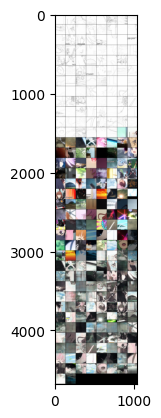

In [10]:


a = traindModel_1.test("1671305935_LatestModel.pth")
b = skimage.metrics.normalized_mutual_information(a[1].to("cpu").numpy(), a[2].to("cpu").numpy())
print(2-b)
MyUtil.show_tensor(torchvision.utils.make_grid(torch.cat(a)))
